In [2]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)

In [3]:
class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type == "RNN":
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size,
                               num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size * self.num_directions, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        # pred = self.act(pred)
        # pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type,
                                                                       hidden_size,
                                                                       num_layers,
                                                                       bidirectional).cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type,
                                                                       hidden_size,
                                                                       num_layers,
                                                                       bidirectional))

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
            # print("Subtracting prediction")
        else:
            pass
            # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print (appliance)
            # print (self.order[appliance])
            # print (args[2+appliance])
            # print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])


In [73]:
import sys
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type == "RNN":
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size,
                               num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size * self.num_directions, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        # pred = self.act(pred)
        # pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type,
                                                                       hidden_size,
                                                                       num_layers,
                                                                       bidirectional).cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type,
                                                                       hidden_size,
                                                                       num_layers,
                                                                       bidirectional))

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
            # print("Subtracting prediction")
        else:
            pass
            # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print (appliance)
            # print (self.order[appliance])
            # print (args[2+appliance])
            # print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])


def disagg_fold(fold_num, dataset, days, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations, p):
    # print (fold_num, hidden_size, num_layers, bidirectional, lr, num_iterations, p)
    #print (ORDER)
    torch.manual_seed(0)

    num_folds=5
    train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)
    # from sklearn.model_selection import train_test_split
    # train, valid = train_test_split(train, test_size=0.2, random_state=0)

    valid = train[int(0.8*len(train)):].copy()
    train = train[:int(0.8 * len(train))].copy()


    train_aggregate = train[:, 0, :, :].reshape(-1, 24*days, 1)
    valid_aggregate = valid[:, 0, :, :].reshape(-1, 24*days, 1)
    test_aggregate = test[:, 0, :, :].reshape(-1, 24*days, 1)


    out_train = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_train[a_num] = Variable(
            torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train_aggregate.shape[0], -1, 1))))
        if cuda_av:
            out_train[a_num] = out_train[a_num].cuda()

    out_valid = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_valid[a_num] = Variable(
            torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid_aggregate.shape[0], -1, 1))))
        if cuda_av:
            out_valid[a_num] = out_valid[a_num].cuda()

    out_test = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_test[a_num] = Variable(
            torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test_aggregate.shape[0], -1, 1))))
        if cuda_av:
            out_test[a_num] = out_test[a_num].cuda()

    loss_func = nn.L1Loss()
    a = AppliancesRNN(cell_type, hidden_size, num_layers, bidirectional, len(ORDER))
    # prevent negative
    #for param in a.parameters():
    #    param.data = param.data.abs()
    #print(a)
    if cuda_av:
        a = a.cuda()
        loss_func = loss_func.cuda()
    optimizer = torch.optim.Adam(a.parameters(), lr=lr)

    inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1, 1))).type(torch.FloatTensor),
                   requires_grad=True)

    valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
    if cuda_av:
        valid_inp = valid_inp.cuda()

    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()

    valid_pred = {}
    train_pred = {}
    test_pred = {}
    test_losses = {}
    valid_losses = {}

    for t in range(1, num_iterations+1):
        idx_train = Variable(torch.LongTensor(np.random.choice(range(train_aggregate.shape[0]), 50, replace=True)))
        inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)

        valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
        test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

        if cuda_av:
            idx_train = idx_train.cuda()
            out = torch.cat(
                [out_train[appliance_num].index_select(0, idx_train) for appliance_num, appliance in enumerate(ORDER)])
            inp = inp.cuda().index_select(0, idx_train)
            out = out.cuda()
        else:
            inp = inp.index_select(0, idx_train)
            out = torch.cat(
                [out_train[appliance_num].index_select(0, idx_train) for appliance_num, appliance in enumerate(ORDER)])

        params = [inp, p]
        for a_num, appliance in enumerate(ORDER):
            params.append(out_train[a_num])
        # print(params)
        pred = a(*params)

        optimizer.zero_grad()
        loss = loss_func(pred, out)
        if t % 50 == 0:
#             print(t, loss.data[0])

            if cuda_av:
                valid_inp = valid_inp.cuda()
            valid_params = [valid_inp, -2]
            for i in range(len(ORDER)):
                valid_params.append(None)
            valid_pr = a(*valid_params)
            valid_loss = loss_func(valid_pr, valid_out)

            if cuda_av:
                test_inp = test_inp.cuda()
            test_params = [test_inp, -2]
            for i in range(len(ORDER)):
                test_params.append(None)
            test_pr = a(*test_params)
            test_loss = loss_func(test_pr, test_out)

            test_losses[t] = test_loss.data[0]
            valid_losses[t] = valid_loss.data[0]
            # np.save("./baseline/p_50_loss")

            if t % 1000 == 0:
                valid_pr = torch.clamp(valid_pr, min=0.)
                valid_pred[t] = valid_pr
                test_pr = torch.clamp(test_pr, min=0.)
                test_pred[t] = test_pr
                train_pr = pred
                train_pr = torch.clamp(train_pr, min=0.)
                train_pred[t] = train_pr

            print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

        loss.backward()
        optimizer.step()

    train_fold = [None for x in range(len(ORDER))]
    valid_fold = {}
    for t in range(1000, num_iterations + 1, 1000):

        valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
        valid_fold[t] = [None for x in range(len(ORDER))]
        if cuda_av:
            for appliance_num, appliance in enumerate(ORDER):
                valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24*days)
        else:
            for appliance_num, appliance in enumerate(ORDER):
                valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24*days)

    test_fold = {}
    for t in range(1000, num_iterations + 1, 1000):

        test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
        test_fold[t] = [None for x in range(len(ORDER))]
        if cuda_av:
            for appliance_num, appliance in enumerate(ORDER):
                test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24*days)
        else:
            for appliance_num, appliance in enumerate(ORDER):
                test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24*days)

    # store ground truth of validation set
    valid_gt_fold = [None for x in range(len(ORDER))]
    for appliance_num, appliance in enumerate(ORDER):
        valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
            valid_aggregate.shape[0],
            -1, 1).reshape(-1, 24*days)

    test_gt_fold = [None for x in range(len(ORDER))]
    for appliance_num, appliance in enumerate(ORDER):
        test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
            test_aggregate.shape[0],
            -1, 1).reshape(-1, 24*days)

    # calcualte the error of validation set
    valid_error = {}
    for t in range(1000, num_iterations + 1, 1000):
        valid_error[t] = {}
        for appliance_num, appliance in enumerate(ORDER):
            valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

    test_error = {}
    for t in range(1000, num_iterations + 1, 1000):
        test_error[t] = {}
        for appliance_num, appliance in enumerate(ORDER):
            test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])

    return train_fold, valid_fold, test_fold, valid_gt_fold, test_gt_fold, valid_error, test_error, valid_losses, test_losses




In [62]:
input_dim = 1
num_folds = 5

In [74]:
fold_num = 0
dataset = 2 
days = 1 
cell_type='GRU' 
hidden_size=20
num_layers=2
bidirectional=True 
lr=0.01
num_iterations=5000 
p=0
ORDER=['dr', 'hvac']

In [75]:
train_fold, valid_fold, test_fold, valid_gt, test_gt, valid_error, test_error, valid_losses, test_losses = disagg_fold(fold_num, dataset, days, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations, p)

Round: 50 Training Error: 467.1283264160156 Validation Error: 421.1189880371094 Test Error: 410.7579345703125
Round: 100 Training Error: 505.49072265625 Validation Error: 414.72198486328125 Test Error: 403.3048400878906
Round: 150 Training Error: 509.4068603515625 Validation Error: 408.8056945800781 Test Error: 396.4116516113281
Round: 200 Training Error: 555.156494140625 Validation Error: 402.88812255859375 Test Error: 389.5310974121094
Round: 250 Training Error: 500.32843017578125 Validation Error: 397.0884704589844 Test Error: 382.7731018066406
Round: 300 Training Error: 414.0354309082031 Validation Error: 391.63323974609375 Test Error: 376.47357177734375
Round: 350 Training Error: 367.3085021972656 Validation Error: 386.2975158691406 Test Error: 370.4898376464844
Round: 400 Training Error: 414.5088806152344 Validation Error: 381.1002197265625 Test Error: 364.7378845214844
Round: 450 Training Error: 446.081298828125 Validation Error: 375.90960693359375 Test Error: 359.0347595214844


Round: 3750 Training Error: 340.00225830078125 Validation Error: 272.6116943359375 Test Error: 241.88174438476562
Round: 3800 Training Error: 312.0483703613281 Validation Error: 271.7012939453125 Test Error: 244.168212890625
Round: 3850 Training Error: 280.74114990234375 Validation Error: 271.01470947265625 Test Error: 242.316650390625
Round: 3900 Training Error: 310.8919372558594 Validation Error: 270.77947998046875 Test Error: 241.4864501953125
Round: 3950 Training Error: 269.4372863769531 Validation Error: 271.6635437011719 Test Error: 245.51541137695312
Round: 4000 Training Error: 318.4880065917969 Validation Error: 270.4733581542969 Test Error: 241.99301147460938
Round: 4050 Training Error: 326.3955078125 Validation Error: 269.8944091796875 Test Error: 238.43406677246094
Round: 4100 Training Error: 314.3794860839844 Validation Error: 270.1464538574219 Test Error: 243.2119140625
Round: 4150 Training Error: 321.51287841796875 Validation Error: 268.7294006347656 Test Error: 239.75204

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

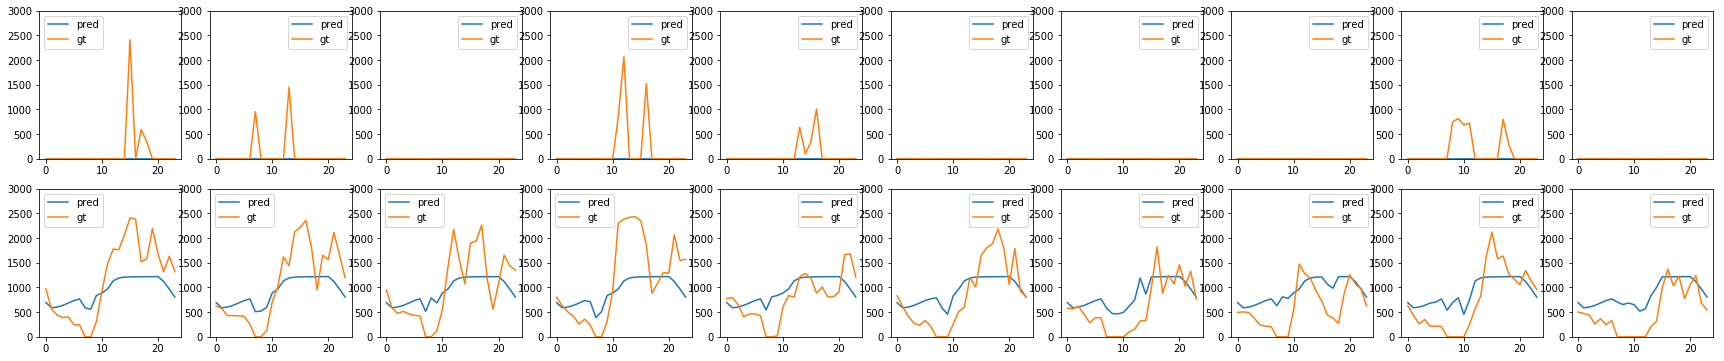

In [85]:


fig, axes = plt.subplots(ncols=10, nrows=2, figsize=(30, 6))
ax = axes.flatten()

for days in range(10):
    
    # for dr
    test_pred = test_fold[5000][0].reshape(-1, 112, 24)
    gt = test_gt[0].reshape(-1 ,112, 24)
    pd.DataFrame(test_pred[0][days]).plot(ax=ax[days])
    pd.DataFrame(gt[0][days]).plot(ax=ax[days])
    
    ax[days].legend(['pred', 'gt'])
    ax[days].set_ylim(0, 3000)
    
for days in range(10):
    # for hvac
    test_pred = test_fold[5000][1].reshape(-1, 112, 24)
    gt = test_gt[1].reshape(-1 ,112, 24)
    pd.DataFrame(test_pred[1][days]).plot(ax=ax[days+10])
    pd.DataFrame(gt[1][days]).plot(ax=ax[days+10])
    
    ax[days+10].legend(['pred', 'gt'])
    ax[days+10].set_ylim(0, 3000)

In [86]:
test_error

{1000: {'dr': 51.272494497233616, 'hvac': 570.74778387151355},
 2000: {'dr': 51.27281711480186, 'hvac': 502.62385456535844},
 3000: {'dr': 51.288144249325363, 'hvac': 489.18768045993642},
 4000: {'dr': 51.282911825222612, 'hvac': 432.70282664609357},
 5000: {'dr': 51.321823843470725, 'hvac': 432.98628058683062}}

In [33]:
days=16
train_fold, valid_fold, test_fold, valid_error, test_error, valid_losses, test_losses = disagg_fold(fold_num, dataset, days, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations, p)

Round: 50 Training Error: 479.1823425292969 Validation Error: 423.2397155761719 Test Error: 413.2216796875
Round: 100 Training Error: 483.8041687011719 Validation Error: 417.28631591796875 Test Error: 406.34344482421875


KeyboardInterrupt: 